In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv(r'./Datasets/credit-default.csv')
print(df.shape)
df.head()

(1000, 21)


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,1,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,2,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,1,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,1,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,2,2,none,yes,skilled employee


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_length       1000 non-null object
installment_rate        1000 non-null int64
personal_status         1000 non-null object
other_debtors           1000 non-null object
residence_history       1000 non-null int64
property                1000 non-null object
age                     1000 non-null int64
installment_plan        1000 non-null object
housing                 1000 non-null object
existing_credits        1000 non-null int64
default                 1000 non-null int64
dependents              1000 non-null int64
telephone               1000 non-null object
foreign_worker          1000 non-null object
jo

In [4]:
## Checking Categorical columns
categorical_cols = df.select_dtypes('object').columns
for col in categorical_cols:
    print(col, ":", df[col].unique())

checking_balance : ['< 0 DM' '1 - 200 DM' 'unknown' '> 200 DM']
credit_history : ['critical' 'repaid' 'delayed' 'fully repaid' 'fully repaid this bank']
purpose : ['radio/tv' 'education' 'furniture' 'car (new)' 'car (used)' 'business'
 'domestic appliances' 'repairs' 'others' 'retraining']
savings_balance : ['unknown' '< 100 DM' '501 - 1000 DM' '> 1000 DM' '101 - 500 DM']
employment_length : ['> 7 yrs' '1 - 4 yrs' '4 - 7 yrs' 'unemployed' '0 - 1 yrs']
personal_status : ['single male' 'female' 'divorced male' 'married male']
other_debtors : ['none' 'guarantor' 'co-applicant']
property : ['real estate' 'building society savings' 'unknown/none' 'other']
installment_plan : ['none' 'bank' 'stores']
housing : ['own' 'for free' 'rent']
telephone : ['yes' 'none']
foreign_worker : ['yes' 'no']
job : ['skilled employee' 'unskilled resident' 'mangement self-employed'
 'unemployed non-resident']


As we can see a lot of columns are categorical in nature, so lets convert them into one hot encoding 

In [5]:
### Converting Caegorical cols to one hot encoding ##
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df.shape)
df.head()

(1000, 49)


,months_loan_duration,amount,installment_rate,residence_history,age,existing_credits,default,dependents,checking_balance_< 0 DM,checking_balance_> 200 DM,...,property_unknown/none,installment_plan_none,installment_plan_stores,housing_own,housing_rent,telephone_yes,foreign_worker_yes,job_skilled employee,job_unemployed non-resident,job_unskilled resident
0,6,1169,4,4,67,2,1,1,1,0,...,0,1,0,1,0,1,1,1,0,0
1,48,5951,2,2,22,1,2,1,0,0,...,0,1,0,1,0,0,1,1,0,0
2,12,2096,2,3,49,1,1,2,0,0,...,0,1,0,1,0,0,1,0,0,1
3,42,7882,2,4,45,1,1,2,1,0,...,0,1,0,0,0,0,1,1,0,0
4,24,4870,3,4,53,2,2,2,1,0,...,1,1,0,0,0,0,1,1,0,0


In [6]:
## Checking if the dataset is balanced or not ##
df['default'].value_counts()

1    700
2    300
Name: default, dtype: int64

Dataset is fairly balanced.

In [7]:
y = df['default']
X = df[df.columns.drop('default')]

In [8]:
## Normalize predictors ##
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
## Train Test Split ##
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=100)
print("Train Size:", X_train.shape, y_train.shape)
print("Test Size", X_test.shape, y_test.shape)

Train Size: (700, 48) (700,)
Test Size (300, 48) (300,)


In [10]:
y_test.value_counts()

1    219
2     81
Name: default, dtype: int64

In [11]:
## Fitting the default logistic regression model ###
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr)

## Test set Performance ##
y_test_pred = lr.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,y_test_pred))
print("F1 Score:",metrics.f1_score(y_test,y_test_pred))
print("Precision:",metrics.precision_score(y_test,y_test_pred))
print("Recall:",metrics.recall_score(y_test,y_test_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy: 0.73
F1 Score: 0.8179775280898877
Precision: 0.8053097345132744
Recall: 0.8310502283105022


Text(0.5, 1.0, 'ROC Curve')

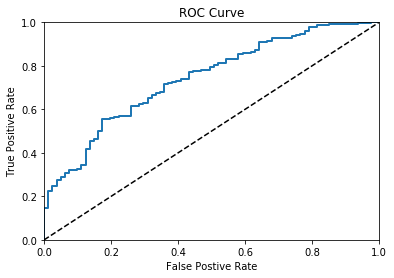

In [12]:
y_test_prob = lr.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob, pos_label=1)

plt.plot(fpr, tpr, linewidth = 2)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [13]:
metrics.roc_auc_score(np.where(y_test==2,0,1),y_test_prob)

0.7409098596313208

#### Implementing Cross Valdation Score

In [14]:
scores = cross_val_score(cv=5, scoring="accuracy", estimator=lr, X=X_train, y= y_train)
scores.mean(), scores.std()

(0.7485868812548746, 0.032572155885326574)

#### Implemeting Grid Search for hyper parameter tuning

In [19]:
#checking the parameters that are available to tune for Logistic Regression
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Parameters
----------
<b>penalty</b> : str, 'l1' or 'l2', default: 'l2'. Used to specify the norm used in the penalization. The 'newton-cg','sag' and 'lbfgs' solvers support only l2 penalties.<br>
<b>tol</b> : float, default: 1e-4. Tolerance for stopping criteria.<br>
<b>C</b> : float, default: 1.0. Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify stronger regularization. <br>
<b>fit_intercept</b>: bool, optional (default=True).Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.<br>
<b>solver</b> : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, optional (default=’lbfgs’)
        Algorithm to use in the optimization problem.
        For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
        For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
        ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
        ‘liblinear’ and ‘saga’ also handle L1 penalty
        ‘saga’ also supports ‘elasticnet’ penalty
        ‘liblinear’ does not support setting penalty='none'<br>
<b>max_iter:</b>: int, optional (default=100). Maximum number of iterations taken for the solvers to converge.


In [65]:
%%time
param_grid = {'C': 10 ** np.linspace(-5, 5, 10),
              'solver': ['newton-cg', 'lbfgs','sag', 'liblinear'],
              'random_state': [100],
              'max_iter': [100,300,500]
}
gridsearch = GridSearchCV(estimator=lr, param_grid=param_grid, scoring="f1", cv=5, verbose=True)
gridsearch.fit(X_train, y_train)

best = gridsearch.best_estimator_
print("Best estimator Params: ",gridsearch.best_params_)
print("Best estimator Accuracy score for test set: ", best.score(X_test, y_test))
y_test_pred = gridsearch.predict(X_test)
print("Best estimator F1 score for test set: ", metrics.f1_score(y_test, y_test_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best estimator Params:  {'C': 0.021544346900318846, 'max_iter': 100, 'random_state': 100, 'solver': 'newton-cg'}
Best estimator Accuracy score for test set:  0.7566666666666667
Best estimator F1 score for test set:  0.8443496801705758
Wall time: 11 s


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   10.9s finished
